In [1]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

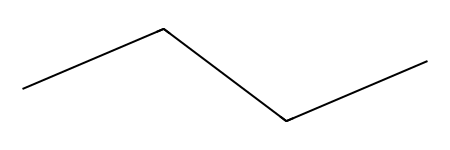

In [4]:
mol = Chem.MolFromSmiles('CCCC')
mol

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file and returns:
      - X: features from columns C to Q (15 columns)
      - y: target from column R (Enhancement Factor)
      - feature_cols: list of feature names
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print(df.head(17)) 

    # Adjust these indices if your CSV differs.
    #  - Column C -> index 2
    #  - Column Q -> index 16
    #  - Column R -> index 17
    feature_cols = df.columns[2:17]  # 15 columns for features
    target_col = df.columns[17]      # 'Enhancement Factor'
    
    X = df[feature_cols].values
    y = df[target_col].values
    
    return X, y, feature_cols

def train_lgbm_model(X, y, test_size=0.2, random_state=42, scale_features=True):
    """
    Trains an LGBMRegressor on the provided features X and target y.
    Uses minimal constraints so that no features are dropped.
    
    Parameters
    ----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : numpy.ndarray
        Target array of shape (n_samples,).
    test_size : float
        Fraction of data to reserve for testing.
    random_state : int
        Seed for reproducible splits and model randomness.
    scale_features : bool
        If True, applies standard scaling to features.

    Returns
    -------
    model : lgb.LGBMRegressor
        Trained LightGBM regression model.
    X_test_scaled : numpy.ndarray
        Scaled test features for predictions.
    y_test : numpy.ndarray
        True target values for the test set.
    scaler : StandardScaler or None
        Fitted scaler if scale_features=True, otherwise None.
    """
    # 1. Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    # 2. Optionally apply feature scaling
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    # 3. Initialize and train the LGBMRegressor
    # Key parameters for tiny datasets:
    # - min_data_in_leaf=1: allows splitting even with very few samples.
    # - min_data_in_bin=1: ensures numeric features aren't over-binned.
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=100,
        min_data_in_leaf=1,
        min_data_in_bin=1,
        random_state=random_state
    )
    model.fit(X_train_scaled, y_train)

    return model, X_test_scaled, y_test, scaler

def evaluate_model(model, X_test, y_test):
    """
    Computes and prints performance metrics:
    - MSE, RMSE, MAE, R², and Adjusted R²
    """
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    n = X_test.shape[0]
    p = X_test.shape[1]
    # Adjusted R² is only valid if (n > p + 1)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else None

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    if adjusted_r2 is not None:
        print(f"Adjusted R² Score: {adjusted_r2:.4f}")
    else:
        print("Adjusted R² Score: Not defined (n <= p + 1).")

def predict_enhancement(model, input_features, scaler=None):
    """
    Predicts the 'Enhancement Factor' for new data.

    Parameters
    ----------
    model : lgb.LGBMRegressor
        Trained LightGBM regression model.
    input_features : array-like of shape (n_samples, n_features)
        New data points for which to predict 'Enhancement Factor'.
    scaler : StandardScaler or None
        If the model was trained with scaling, pass the fitted scaler here.

    Returns
    -------
    predictions : numpy.ndarray
        Predicted Enhancement Factor values.
    """
    if scaler is not None:
        input_features = scaler.transform(input_features)
    
    return model.predict(input_features)

if __name__ == "__main__":
    # 1. Load dataset from CSV
    csv_file = "drug_descriptors.csv"  # Replace with your actual CSV
    X, y, feature_cols = load_dataset(csv_file)
    
    # 2. Train the refined LGBM model
    model, X_test_scaled, y_test, scaler = train_lgbm_model(
        X, y,
        test_size=0.2,  # 80% train, 20% test
        random_state=42,
        scale_features=True
    )
    
    # 3. Evaluate the model
    evaluate_model(model, X_test_scaled, y_test)
    
    # 4. Example: Predict Enhancement Factor for new data (placeholder features)
    new_data = np.array([
        [1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11, 0.23, 5.52, 0.33, 0.1, 1, 0, 0, 1]
    ])
    prediction = predict_enhancement(model, new_data, scaler=scaler)
    print("\nPredicted Enhancement Factor:", prediction)




    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(=O)O)C(=O)c1ccc(c

Now here is an improved lgbm model
=
=
=
=
=
=
=
=
=
=

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file and returns:
      - X: features from columns C to Q (15 columns)
      - y: target from column R (Enhancement Factor)
      - feature_cols: list of feature names
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print("Dataset preview:")
    print(df.head(17))
    
    # Adjust these indices if needed:
    #  - Column C -> index 2
    #  - Column Q -> index 16 (15 columns)
    #  - Column R -> index 17 (Enhancement Factor)
    feature_cols = df.columns[2:17]
    target_col = df.columns[17]
    
    X = df[feature_cols].values
    y = df[target_col].values
    
    return X, y, feature_cols

def train_lgbm_model(
    X, y,
    test_size=0.2,
    random_state=42,
    scale_features=True,
    log_transform=True
):
    """
    Trains a LightGBM regressor on a single train-test split with a fixed set
    of hyperparameters and optional log transform of the target.
    
    Parameters
    ----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : numpy.ndarray
        Target array of shape (n_samples,).
    test_size : float
        Fraction of data to reserve for validation/test.
    random_state : int
        Seed for reproducible splits and model randomness.
    scale_features : bool
        If True, applies standard scaling to features.
    log_transform : bool
        If True, transform target with log1p (log(1 + y)).

    Returns
    -------
    model : lgb.LGBMRegressor
        Trained LightGBM regression model.
    X_test : numpy.ndarray
        Scaled test features.
    y_test : numpy.ndarray
        True target values for the test set (in original scale if log_transform=True).
    scaler : StandardScaler or None
        Fitted scaler if scale_features=True, otherwise None.
    log_transform_used : bool
        Whether or not log transform was applied.
    """
    # 1. (Optional) log transform the target
    if log_transform:
        y = np.log1p(y)  # log(1 + y)

    # 2. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 3. (Optional) feature scaling
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # 4. Define a fixed LightGBM regressor (no hyperparameter tuning)
    #    You can adjust these parameters if needed.
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=500,
        learning_rate=0.00005,
        num_leaves=31,
        min_child_samples=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=0.01,
        random_state=random_state,
        n_jobs=-1
    )

    # 5. Fit with early stopping
    #    (Use a small validation set from the training portion to monitor)
    #    We'll do a manual split from X_train if data is sufficient
    val_fraction = 0.15  # portion of training data for early-stopping
    val_size = int(len(X_train) * val_fraction)
    X_train_main, X_val = X_train[:-val_size], X_train[-val_size:]
    y_train_main, y_val = y_train[:-val_size], y_train[-val_size:]
    
    model.fit(
        X_train_main, y_train_main,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )

    # 6. If log_transform was used, invert transform for y_test so metrics are in original scale
    if log_transform:
        y_test = np.expm1(y_test)  # revert log transform

    return model, X_test, y_test, scaler, log_transform

def evaluate_model(model, X_test, y_test, log_transform=False):
    """
    Computes and prints performance metrics: MSE, RMSE, MAE, R², and Adjusted R².
    If log_transform=True, predictions are exponentiated (minus 1) before computing metrics.
    """
    preds = model.predict(X_test)

    # Invert log transform if used
    if log_transform:
        preds = np.expm1(preds)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = None
    if n > p + 1:
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    if adjusted_r2 is not None:
        print(f"Adjusted R² Score: {adjusted_r2:.4f}")
    else:
        print("Adjusted R² Score: Not defined (n <= p + 1).")

def predict_enhancement(model, input_features, scaler=None, log_transform=False):
    """
    Predicts the 'Enhancement Factor' for new data.
    
    Parameters
    ----------
    model : lgb.LGBMRegressor
        Trained LightGBM regression model.
    input_features : array-like of shape (n_samples, n_features)
        New data points for which to predict the 'Enhancement Factor'.
    scaler : StandardScaler or None
        If the model was trained with scaling, pass the fitted scaler here.
    log_transform : bool
        Whether the model was trained on log-transformed target.
    
    Returns
    -------
    predictions : numpy.ndarray
        Predicted Enhancement Factor values (in original scale if log_transform=True).
    """
    if scaler is not None:
        input_features = scaler.transform(input_features)

    preds = model.predict(input_features)
    if log_transform:
        preds = np.expm1(preds)  # revert log transform

    return preds

# ------------------------------
# Example usage
if __name__ == "__main__":
    csv_file = "C:/Users/gagno/Downloads/molecule_features.csv"
    X, y, feature_cols = load_dataset(csv_file)

    # Train the model (with log transform, no hyperparameter tuning)
    model, X_test, y_test, scaler, used_log = train_lgbm_model(
        X, y,
        test_size=0.2,
        random_state=42,
        scale_features=True,
        log_transform=True
    )
    
    # Evaluate on test set
    evaluate_model(model, X_test, y_test, log_transform=used_log)
    
    # Predict on new data
    new_data = np.array([
        [1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11, 0.23, 5.52, 0.33, 0.1, 1, 0, 0, 1]
    ])
    prediction = predict_enhancement(model, new_data, scaler=scaler, log_transform=used_log)
    print("\nPredicted Enhancement Factor:", prediction)




Dataset preview:
    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 40, number of used features: 15
[LightGBM] [Info] Start training from score 1814.221882

=== LIGHTGBM TRAINING-SET PERFORMANCE ===
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
Mean Squared Error (MSE): 0.0264
Root Mean Squared Error (RMSE): 0.1626
Mean Absolute Error (MAE): 0.0844
R² Score: 1.0000
Adjusted R² Score: 1.0000

=== LIGHTGBM TEST-SET PERFORMANCE ===
[Lig

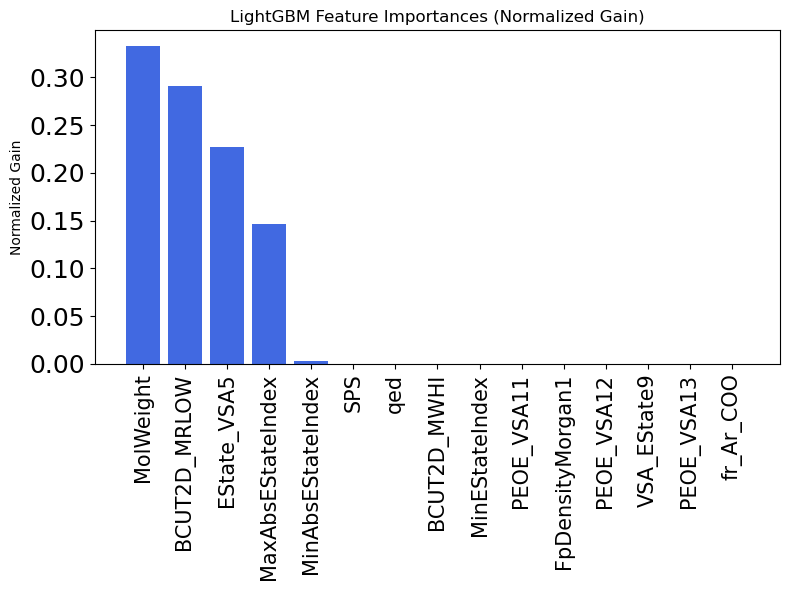

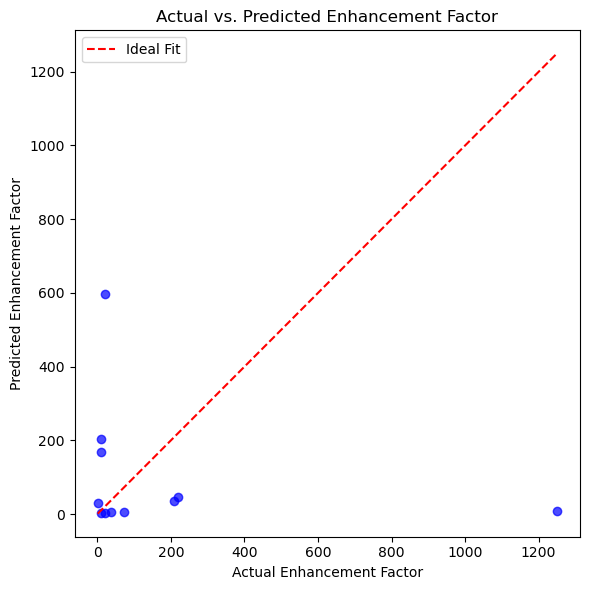

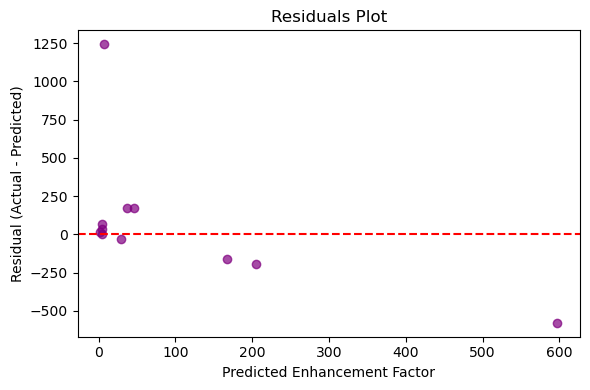

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ------------------------------
# 1. LOAD AND PREPARE DATA
# ------------------------------
def load_dataset(file_path):
    """
    Loads the dataset from a CSV file. 
    Expects 15 molecular features in columns C to Q (indices 2:17),
    and the target 'Enhancement Factor' in column R (index 17).
    
    Returns
    -------
    X : np.ndarray
        2D array of shape (n_samples, 15) with feature values
    y : np.ndarray
        1D array of shape (n_samples,) with target values
    feature_cols : list
        Names of the feature columns
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)

    # Adjust indices if your CSV differs
    feature_cols = df.columns[2:17]   # columns C->Q
    target_col = df.columns[17]       # column R

    X = df[feature_cols].values
    y = df[target_col].values

    return X, y, feature_cols

# ------------------------------
# 2. TRAIN LGBM MODEL
# ------------------------------
def train_lgbm_model(X, y, test_size=0.2, random_state=42, scale_features=True):
    """
    Splits data, optionally scales features, and trains a LightGBM Regressor.
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix (n_samples x 15)
    y : np.ndarray
        Target array (n_samples,)
    test_size : float
        Fraction of data for test
    random_state : int
        Seed for reproducible splits
    scale_features : bool
        Whether to apply standard scaling to features

    Returns
    -------
    model : lgb.LGBMRegressor
        Trained LightGBM model
    X_train_scaled, X_test_scaled : np.ndarray
        Scaled feature matrices for train and test sets
    y_train, y_test : np.ndarray
        Corresponding target arrays for train and test sets
    scaler : StandardScaler or None
        Fitted scaler if scale_features=True, else None
    """
    # 1. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    # 2. Optional scaling
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    # 3. LightGBM regressor
    # For very small data, we relax min_data_in_leaf and min_data_in_bin
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=100,
        min_data_in_leaf=1,
        min_data_in_bin=1,
        random_state=random_state
    )
    model.fit(X_train_scaled, y_train)

    return model, X_train_scaled, X_test_scaled, y_train, y_test, scaler

# ------------------------------
# 3. EVALUATE MODEL
# ------------------------------
def evaluate_model(model, X_test, y_test):
    """
    Computes and prints:
      - MSE, RMSE, MAE
      - R²
      - Adjusted R² (if n > p + 1)
    """
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else None

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    if adjusted_r2 is not None:
        print(f"Adjusted R² Score: {adjusted_r2:.4f}")
    else:
        print("Adjusted R² Score: Not defined (n <= p + 1).")

    return predictions

# ------------------------------
# 4. FEATURE IMPORTANCE
# ------------------------------
def plot_feature_importances(model, feature_cols, max_features=None):
    """
    Plots normalized LightGBM feature importances using the gain-based measure.
    The importance values are normalized so that their sum equals 1.
    
    Parameters
    ----------
    model : lgb.LGBMRegressor
        A trained LightGBM model.
    feature_cols : list
        List of feature names corresponding to the columns used to train the model.
    max_features : int, optional
        If specified, only the top 'max_features' will be displayed.
    """
    # Retrieve gain-based importances from the LightGBM model's booster
    importances = model.booster_.feature_importance(importance_type='gain')
    
    # Normalize the importances so that they sum up to 1
    total_gain = importances.sum()
    normalized_importances = importances / total_gain if total_gain > 0 else importances
    
    # Pair each importance with its corresponding feature name
    feature_importance_pairs = list(zip(feature_cols, normalized_importances))
    # Sort features in descending order based on normalized importance
    feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
    
    if max_features is not None:
        feature_importance_pairs = feature_importance_pairs[:max_features]
    
    # Unzip the sorted pairs
    labels, scores = zip(*feature_importance_pairs)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.title("LightGBM Feature Importances (Normalized Gain)")
    plt.bar(range(len(scores)), scores, color="royalblue")
    plt.ylabel("Normalized Gain")
    plt.xticks(range(len(scores)), labels, rotation=90, fontsize=15)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()


# ------------------------------
# 5. ADDITIONAL VISUALIZATIONS
# ------------------------------
def plot_predictions_vs_actual(y_test, y_pred):
    """
    Scatter plot of actual vs. predicted 'Enhancement Factor' values.
    Also draws a y=x reference line.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel("Actual Enhancement Factor")
    plt.ylabel("Predicted Enhancement Factor")
    plt.title("Actual vs. Predicted Enhancement Factor")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(y_test, y_pred):
    """
    Residuals plot: predicted vs. error (y_test - y_pred).
    Helps visualize how predictions deviate from actual.
    """
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, color='purple', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Enhancement Factor")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title("Residuals Plot")
    plt.tight_layout()
    plt.show()

# ------------------------------
# MAIN EXECUTION
# ------------------------------
if __name__ == "__main__":
    # 1. Load data
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path) # Replace with your actual CSV file path
    X, y, feature_cols = load_dataset(file_path)

    # 2. Train the model
    model, X_train_scaled, X_test_scaled, y_train, y_test, scaler = train_lgbm_model(
        X, y,
        test_size=0.2,  # 80% train, 20% test
        random_state=42,
        scale_features=True
    )

    # 3. Evaluate
    print("\n=== LIGHTGBM TRAINING-SET PERFORMANCE ===")
    _ = evaluate_model(model, X_train_scaled, y_train)

    # 3b. Evaluate on the **test** set
    print("\n=== LIGHTGBM TEST-SET PERFORMANCE ===")
    y_pred = evaluate_model(model, X_test_scaled, y_test)

    # 4. Feature Importance Analysis
    #    Show up to all 15 features
    plot_feature_importances(model, feature_cols, max_features=15)

    # 5. Additional Visualizations
    plot_predictions_vs_actual(y_test, y_pred)
    plot_residuals(y_test, y_pred)




In [19]:
def plot_residuals(y_test, y_pred):
    """
    Residuals plot: predicted vs. error (y_test - y_pred).
    Helps visualize how predictions deviate from actual.
    """
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, color='purple', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Enhancement Factor")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title("Residuals Plot")
    plt.tight_layout()
    plt.show()
